In [1]:
%load_ext autoreload

import torch
import math
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from numpy.lib.stride_tricks import sliding_window_view
from last_layer_models import LLI, train_last_layer_det, get_post_pred_dens
from gibbs_sampler import gibbs_sampler, get_pred_post_dist
from torch.distributions import MultivariateNormal, Normal

import seaborn as sns

/Users/clarahoffmann/Documents/code/last_layer_inference/last-layer-inf/src/last_layer_inf/gibbs_sampler.py:80: SyntaxWarning: invalid escape sequence '\i'
  The pred. mean and standard deviation are integrated numericall via by \int y *pdf(y) dy


Text(0.5, 1.0, 'Training/Validation split')

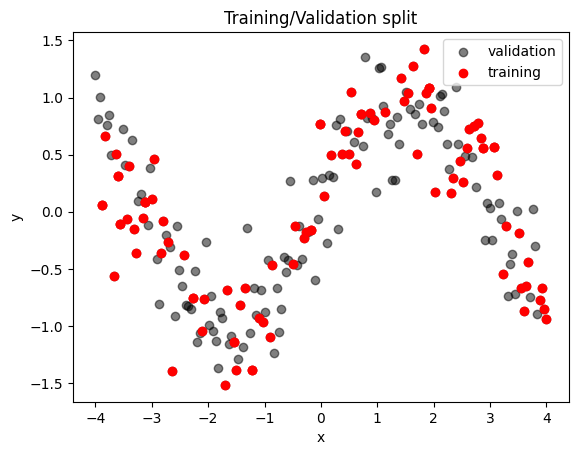

In [2]:
def f(x: float, noise: bool = True, sigma_eps: float = 0.1):
    """Generates a sample y_i from y = sin(x) + varepsilon."""
    y = math.sin(x)
    if noise:
        y += sigma_eps*np.random.randn(1)
    return y

# draw data
sigma_eps = 0.3
xs = np.linspace(-4,4,200)
ys = np.array([f(x = x, noise = True, sigma_eps = sigma_eps) for x in xs])

# sample train indices
train_idx = np.random.randint(0, len(xs), 100)

xs_train = torch.tensor(xs[train_idx]).unsqueeze(-1).float()
ys_train = torch.tensor(ys[train_idx]).float()

# visualize train/val split
fig, axs = plt.subplots(1,1)
axs.scatter(xs, ys, c = 'black', label = 'validation', alpha =.5)
axs.scatter(xs_train, ys_train, c = 'red', label = 'training', alpha = 1)
axs.legend()
axs.set_xlabel('x')
axs.set_ylabel('y')
axs.set_title("Training/Validation split")

In [3]:
data = TensorDataset(xs_train, ys_train)
train_set, val_set = torch.utils.data.random_split(data, [80, 20])
dataloader_train = DataLoader(train_set, shuffle = True, batch_size=5)
dataloader_val = DataLoader(val_set, shuffle = True, batch_size=20)

In [4]:
model_dims = [1, 100, 100, 100, 50, 1]
num_epochs = 100

100%|██████████| 100/100 [00:00<00:00, 182.98it/s]


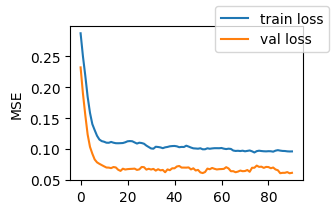

In [5]:
lli_net = LLI(model_dims)
sigma_0 = 0.3

lli_net, losses_train, losses_val = train_last_layer_det(model = lli_net, 
                                                         dataloader_train = dataloader_train,
                                                         dataloader_val = dataloader_val, 
                                                         num_epochs = num_epochs)
fig, axs = plt.subplots(1,1, figsize = (3,2))
axs.plot(sliding_window_view(np.array(losses_train), 10).mean(axis=1), label = 'train loss')
axs.plot(sliding_window_view(np.array(losses_val), 10).mean(axis=1), label = 'val loss')
axs.set_ylabel('MSE')
fig.legend()

In [6]:
lli_net.eval()
Psi = lli_net.get_ll_embedd(xs_train)

In [7]:
a_tau = 0
b_tau = .2
a_sigma = 0
b_sigma = .2
num_iter = 10
w_sample, tau_sq_sample, sigma_sq_sample = gibbs_sampler(Psi, ys_train, a_tau, b_tau, a_sigma, b_sigma, 100, 10)

100%|██████████| 100/100 [00:00<00:00, 1513.20it/s]


In [16]:
ys_grid = torch.arange(-5,5, .01)

preds = {'mean': [],
         'var': []}
for i in range(Psi.shape[0]):
    _, y_mean, y_var = get_pred_post_dist(Psi[i], w_sample, sigma_sq_sample, ys_grid)
    preds['mean'].append(y_mean)
    preds['var'].append(y_var)

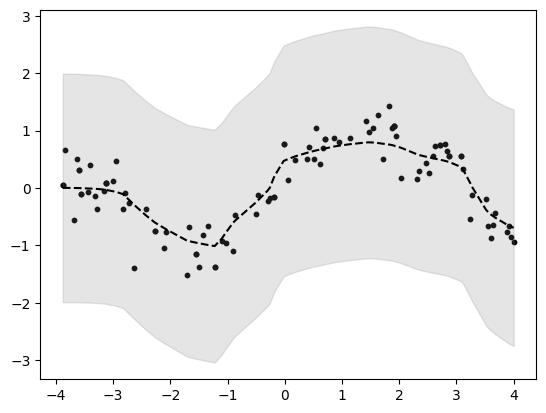

In [38]:
# for some reason these are not sorted yet. clean this up later
xs_np = xs_train.detach().cpu().numpy().squeeze()

sorted_idx = np.argsort(xs_np)
xs_sorted = xs_np[sorted_idx]
pred_mean_sorted = np.array(preds['mean']).squeeze()[sorted_idx]
pred_std_sorted = np.sqrt(np.array(preds['var']).squeeze()[sorted_idx])

plt.scatter(xs_train, ys_train, c = 'black', label = 'observed data', alpha = 1, s = 10)
plt.plot(xs_sorted, pred_mean_sorted, c='black', linestyle='dashed', label='posterior mean')
plt.fill_between(xs_sorted, pred_mean_sorted - 2*pred_std_sorted,  pred_mean_sorted + 2*pred_std_sorted, color = 'grey', alpha = 0.2)

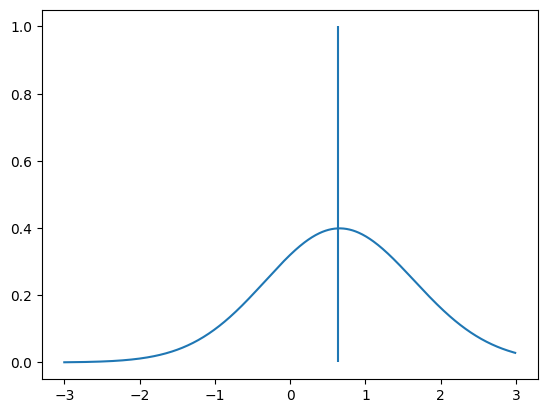

In [9]:
plt.plot(ys_grid, py_hat)
plt.vlines(y_mean, 0,1)